# 1. Load the dataset
And prepare it by matchin images and annotations.

In [1]:
import pickle

# file_path = 'drive/My Drive/Deep Learning Project/refcocog/refcocog/annotations/refs(umd).p'
file_path = 'refcocog/annotations/refs(umd).p'

file = open(file_path, 'rb')

# Load pickle data
data = pickle.load(file)

# close the file
file.close()

In [2]:
import json

file_path = 'refcocog/annotations/instances.json'

file = open(file_path, 'rb')

instances = json.load(file)

file.close()

In [3]:
# This version takes ~0.1 seconds to run

matches = {}

images_actual_file_names = {}
for image in instances['images']:
    images_actual_file_names[image['id']] = image['file_name']

for image in data:
    if image['ann_id'] not in matches:
        matches[image['ann_id']] = {}

    matches[image['ann_id']]['image'] = image
    matches[image['ann_id']]['image']['actual_file_name'] = images_actual_file_names[image['image_id']]

for annotation in instances['annotations']:
    if annotation['id'] not in matches:
        continue

    matches[annotation['id']]['annotation'] = annotation

Prompt: A light-colored car in the background behind a chain-link fence
Prompt: silver car in parking lot


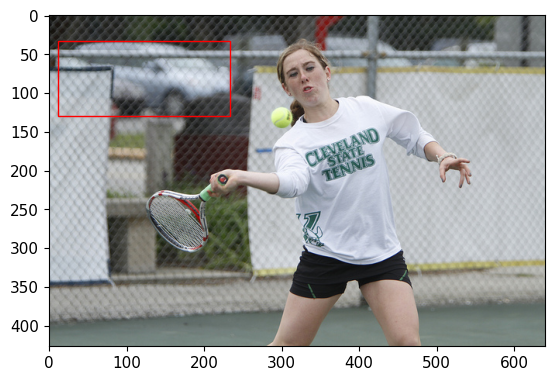

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

folder_path = 'refcocog/images/'

# First image in the dataset
test_sample = matches[list(matches.keys())[0]]
# test_sample = matches[list(matches.keys())[4]]
test_sample = matches[list(matches.keys())[897]]
# test_sample = matches[list(matches.keys())[42]]
# test_sample = matches[list(matches.keys())[420]]

# Loading the image
img = Image.open(folder_path + test_sample['image']['actual_file_name'])

# Preparing the output
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Create a Rectangle patch
bounding_box_coordinates = test_sample['annotation']['bbox']
top_left_x, top_left_y = bounding_box_coordinates[0], bounding_box_coordinates[1]
width, height = bounding_box_coordinates[2], bounding_box_coordinates[3]

# Parameters: (x, y), width, height
rect = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

# plt.show()

# Display prompt
for prompt in test_sample['image']['sentences']:
    print(f"Prompt: {prompt['raw']}")

# 2. Load CLIP

In [32]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device) # We should use RN50
# However, it performs much more poorly than ViT-B/32! This has to be investigated

## 2.1 Test CLIP

In [33]:
%matplotlib inline

image = preprocess(Image.open(folder_path + test_sample['image']['actual_file_name'])).unsqueeze(0).to(device)
# prompts = [
#     test_sample['image']['sentences'][0]['raw'],
#     # 'a photograph of a dark brown dog'
#     # 'a photo of ' + test_sample['image']['sentences'][0]['raw'],
#     # 'a picutre of ' + test_sample['image']['sentences'][0]['raw'],
#     # 'a photograph of ' + test_sample['image']['sentences'][0]['raw'],
# ]
prompts = [
    prompt['raw'] for prompt in test_sample['image']['sentences']
]
text = clip.tokenize(prompts).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print('Probabilities:')
for prompt, prob in zip(prompts, probs[0]):
    print(f'• "{prompt}": {prob}')

# print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Probabilities:
• "A light-colored car in the background behind a chain-link fence": 0.9999138116836548
• "silver car in parking lot": 8.618397259851918e-05


In [34]:
test_sample

{'image': {'image_id': 475415,
  'split': 'test',
  'sentences': [{'tokens': ['a',
     'light',
     '-',
     'colored',
     'car',
     'in',
     'the',
     'background',
     'behind',
     'a',
     'chain',
     '-',
     'link',
     'fence'],
    'raw': 'A light-colored car in the background behind a chain-link fence',
    'sent_id': 20145,
    'sent': 'a light - colored car in the background behind a chain - link fence'},
   {'tokens': ['silver', 'car', 'in', 'parking', 'lot'],
    'raw': 'silver car in parking lot',
    'sent_id': 20146,
    'sent': 'silver car in parking lot'}],
  'file_name': 'COCO_train2014_000000475415_361093.jpg',
  'category_id': 3,
  'ann_id': 361093,
  'sent_ids': [20145, 20146],
  'ref_id': 897,
  'actual_file_name': 'COCO_train2014_000000475415.jpg'},
 'annotation': {'segmentation': [[37.51,
    39.91,
    117.33,
    32.22,
    177.92,
    41.83,
    180.8,
    45.68,
    41.35,
    46.64],
   [13.46,
    55.3,
    196.19,
    56.26,
    221.19,

# 3. Load YOLO

In [35]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /Users/marco/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-4 Python-3.11.1 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


## 3.1 Test YOLO

image 1/1: 427x640 1 person, 2 cars, 1 sports ball, 1 tennis racket
Speed: 7.6ms pre-process, 98.5ms inference, 1.0ms NMS per image at shape (1, 3, 448, 640)


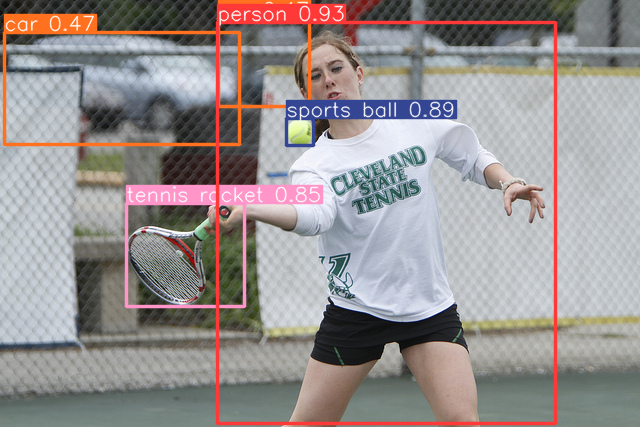

,xmin,ymin,xmax,ymax,confidence,class,name
0,217.424942,22.760208,555.468201,423.258240,0.929388,0,person
1,286.711731,118.191788,313.093628,145.358292,0.885048,32,sports ball
2,126.206337,203.056427,244.777039,306.550507,0.854270,38,tennis racket
3,4.743652,32.825592,239.115784,144.268417,0.471767,2,car
4,218.438965,18.706417,309.120850,106.511200,0.466162,2,car


In [36]:
images = [folder_path + test_sample['image']['actual_file_name']]

results = yolo_model(images)

# Results
results.print()
# results.save()  # or .show()
results.show()

results.xyxy[0]  # img1 predictions (tensor)
results.pandas().xyxy[0]  # img1 predictions (pandas)

## 3.2 Crop Bounding Boxes

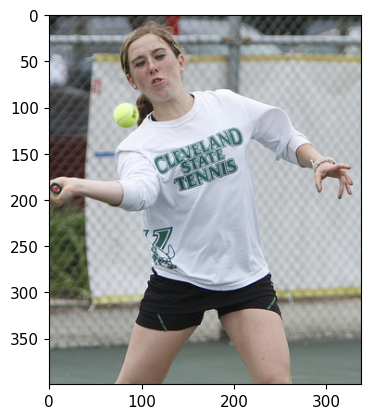

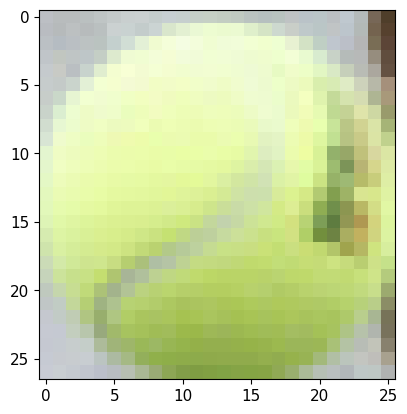

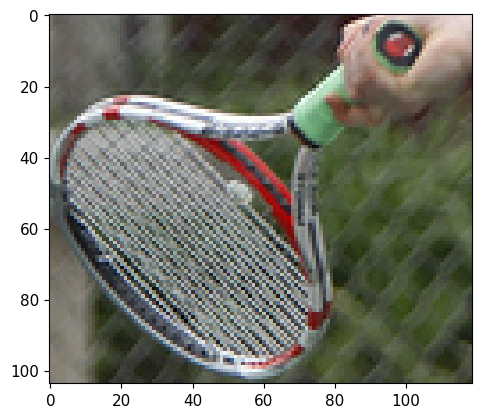

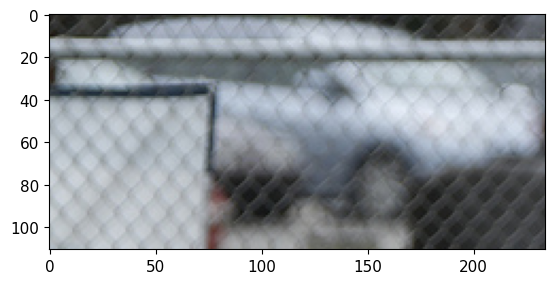

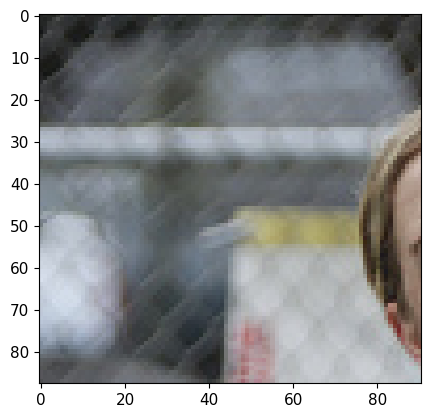

In [37]:
%matplotlib inline

from PIL import Image

image = Image.open(images[0])
cropped_bounding_boxes = []
for bounding_box in results.xyxy[0]:
    # top_left_x, top_left_y = bounding_box[0], bounding_box[1]
    # width, height = bounding_box[2] - top_left_x, bounding_box[3] - top_left_y
    # bounding_box = results.xyxy[0][0]

    cropped_img = image.crop((bounding_box[0].item(), bounding_box[1].item(), bounding_box[2].item(), bounding_box[3].item()))
    cropped_bounding_boxes.append(cropped_img)

    # Preparing the output
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(cropped_img)

    # plt.show()

# 4. Compare YOLO's bounding boxes with text prompt using CLIP

In [38]:
preprocessed_images = [preprocess(cropped_img).to(device) for cropped_img in cropped_bounding_boxes]

# Images are stacked onto a tensor so that 
preprocessed_images = torch.stack(preprocessed_images)

In [39]:
# Using logits_per_text instead of logits_per_image because
# the score has to be computed on a prompt basis (that is, the sum of the
# probabilities across all the images for each text prompt has to sum up to
# 1)
with torch.no_grad():
    image_features = model.encode_image(preprocessed_images)
    logits_per_image, logits_per_text = model(preprocessed_images, text)

    probs = logits_per_text.softmax(dim=-1).cpu().numpy()

In [40]:
probs, probs.sum(axis=1), probs.sum()

(array([[ 4.0587e-05,  9.4961e-06,  0.00043622,      0.9891,    0.010411],
        [ 0.00021405,    0.022232,   0.0027952,     0.95487,    0.019892]], dtype=float32),
 array([          1,           1], dtype=float32),
 2.0)

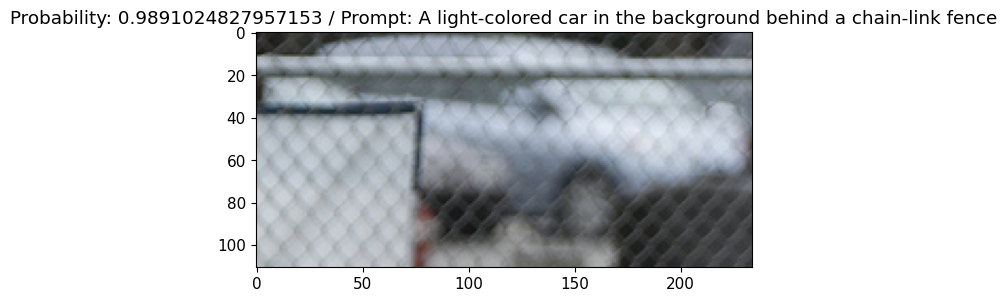

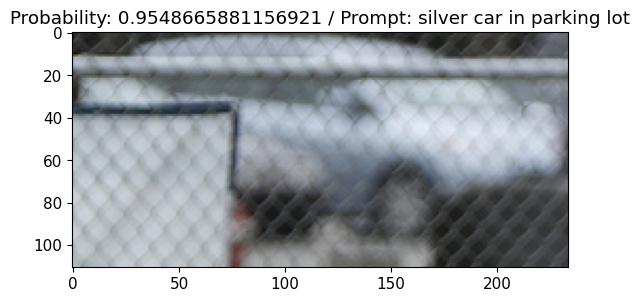

In [41]:
%matplotlib inline

import numpy as np

for i in range(probs.shape[0]):
    index_of_max = np.array(probs[i]).argmax()

    fix, ax = plt.subplots()
    ax.imshow(cropped_bounding_boxes[index_of_max])
    ax.set_title(f'Probability: {np.array(probs[i]).max()} / Prompt: {prompts[i]}')

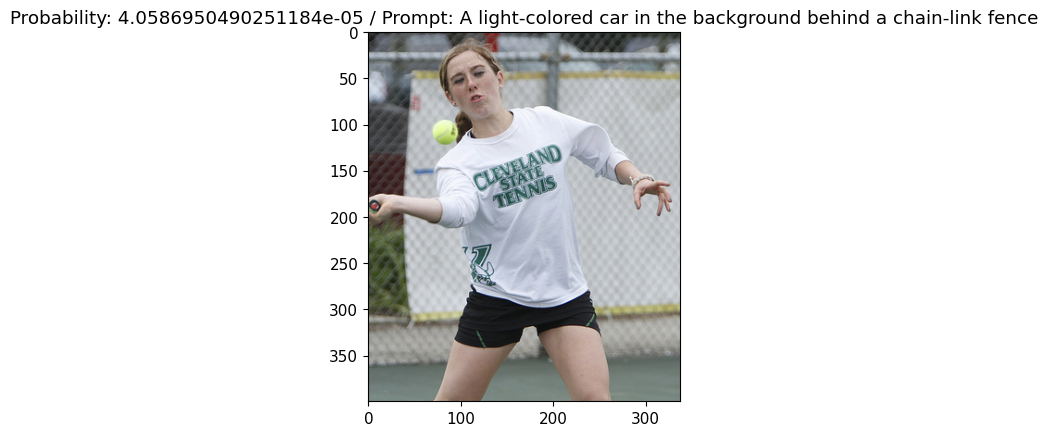

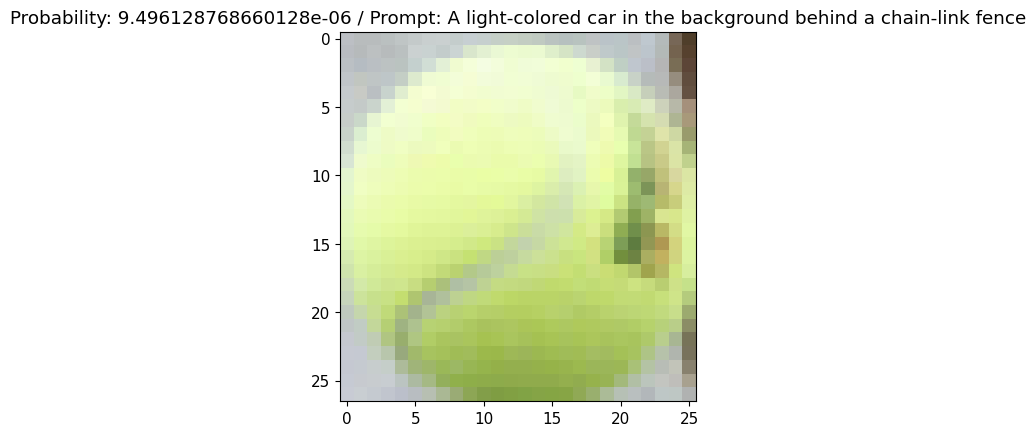

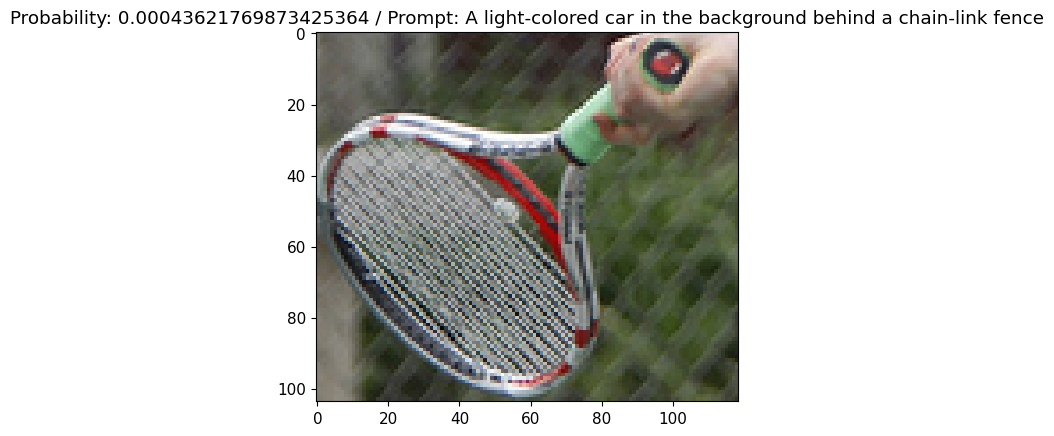

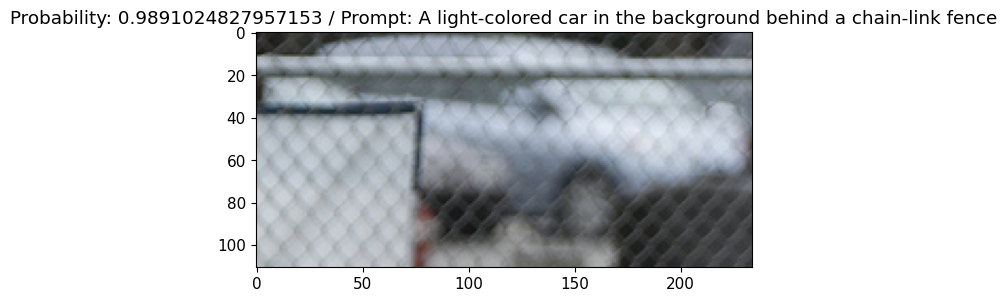

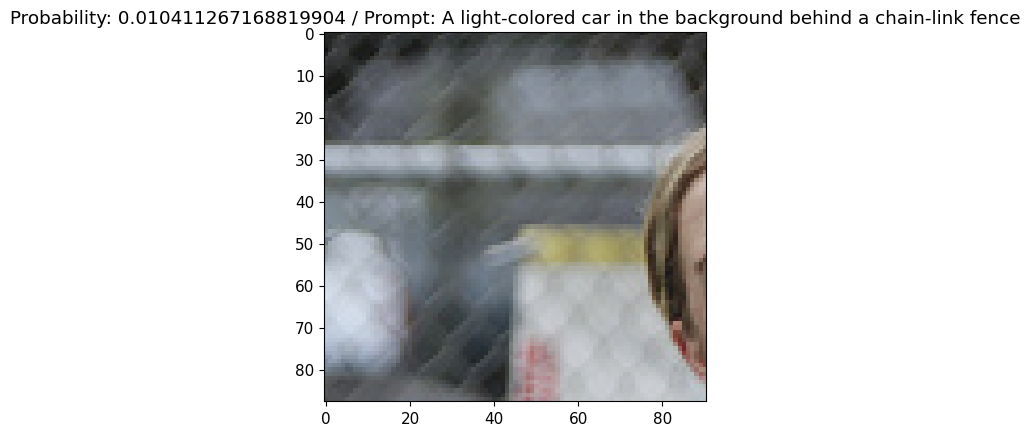

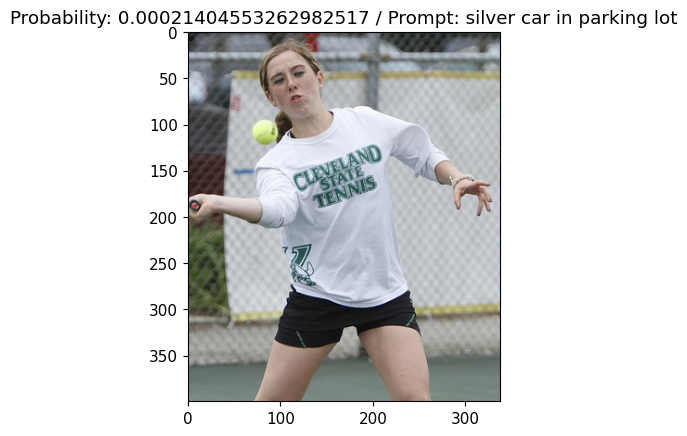

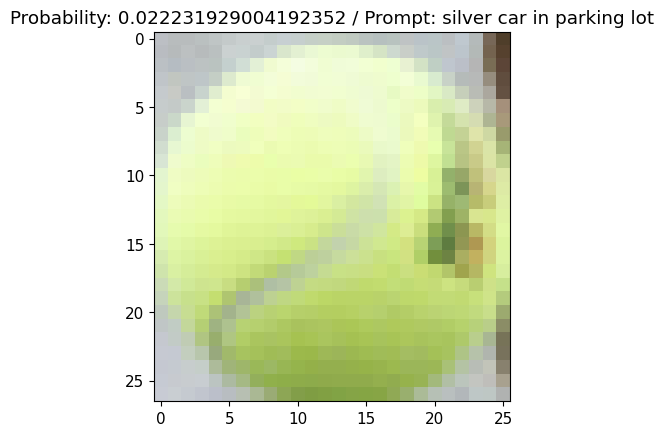

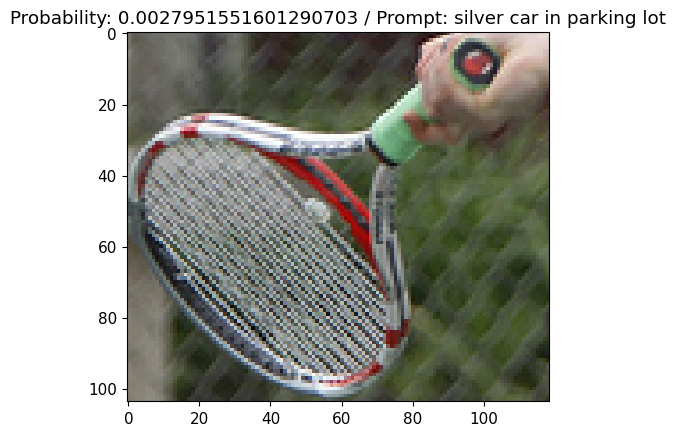

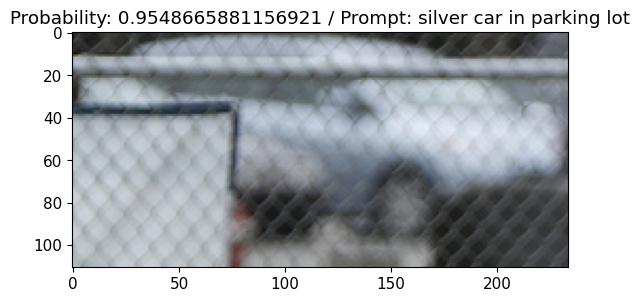

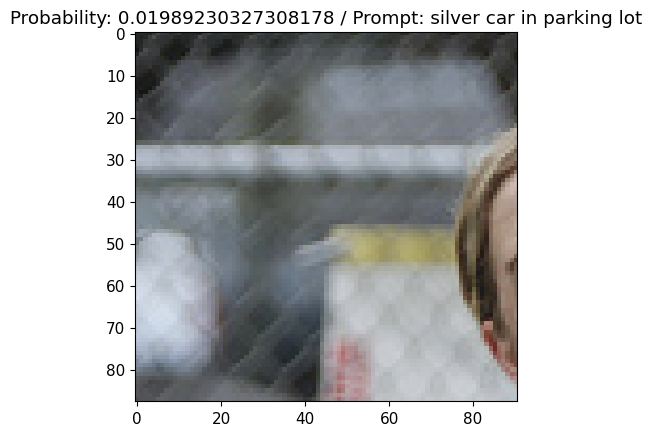

In [42]:
%matplotlib inline

for prompt, probs_for_text in zip(prompts, probs):
    for cropped_img, prob in zip(cropped_bounding_boxes, probs_for_text):
        # Preparing the output
        fig, ax = plt.subplots()

        # Display the image
        ax.imshow(cropped_img)
        ax.set_title(f'Probability: {prob} / Prompt: {prompt}')